In [19]:
import importlib

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import shuffle
import torch
import utils
import model2
importlib.reload(utils)
importlib.reload(model2)
from utils import *
from model2 import *
tf.test.is_built_with_cuda()

False

In [20]:

dic = get_dict_icon_sketches()

icons, icons_name_cat = load_icons(dic)
sketches, sketch_names_array = load_sketches(dic)

sketch_icon_indices, positive_labels = create_positive_sketch_icon_indices(icons_name_cat, sketch_names_array)
print(f'We have {len(sketch_icon_indices)} samples.')
# shuffle the indices and labels
sketch_icon_indices, positive_labels = shuffle(sketch_icon_indices, positive_labels)

We have 1708 samples.


In [26]:
NEGATIVE_PAIRS_LEN = 1

class Dataset():
    def __init__(self, indices, labels):
        self.indices = indices
        self.labels = labels

    def __len__(self):
        # Return the size of the dataset
        return len(self.indices)

    def __getitem__(self, index):
        # Retrieve indices and labels at the given index
        indices = self.indices[index]
        label = self.labels[index]

        return indices, label

def create_datasets(sketch_icon_indices, labels, dataset_class, p_train=0.8, p_test=0.2):
    len_data = len(sketch_icon_indices)

    # Define partition sizes
    num_train = int(np.ceil(len_data*p_train))
    num_test = int(np.floor(len_data*p_test))

    sketch_icon_indices_Train, positive_labels_Train = sketch_icon_indices[:num_train], labels[:num_train]
    sketch_icon_indices_Test, labels_test = sketch_icon_indices[-num_test:], labels[-num_test:]

    negative_indices, negative_labels_Train = create_negative_sketch_icon_indices(sketch_icon_indices_Train, NEGATIVE_PAIRS_LEN)
    print(f'We have {len(sketch_icon_indices_Train)} positive pair samples in the training set.')
    print(f'We have {len(negative_indices)} negative pair samples in the training set.')

    negative_array = np.array(negative_indices)
    # This array includes the posititive and negative pair indices
    pair_indices_Train = np.concatenate((sketch_icon_indices_Train, negative_array), axis=0)
    labels_Train = np.concatenate((positive_labels_Train, negative_labels_Train), axis=0)

    training_set = dataset_class(pair_indices_Train, labels_Train)
    test_set = dataset_class(sketch_icon_indices_Test, labels_test)
    return training_set, test_set

training_set, test_set = create_datasets(sketch_icon_indices, positive_labels, Dataset)   
print(f'We have {len(training_set)} samples in the training set.')
print(f'We have {len(test_set)} samples in the test set.')

We have 1367 positive pair samples in the training set.
We have 1367 negative pair samples in the training set.
We have 2734 samples in the training set.
We have 341 samples in the test set.


In [27]:
batch_size = 64

def load_dataset():

    trainloader = torch.utils.data.DataLoader(
      dataset = training_set,
      batch_size= batch_size,
      num_workers = 0,
      shuffle= True
    )

    testloader = torch.utils.data.DataLoader(
      dataset = test_set,
      batch_size= batch_size,
      num_workers= 0,
      shuffle= False
    )

    return trainloader, testloader

trainloader, testloader = load_dataset()

In [28]:
num_epochs = 100
margin = 1
optimizer = tf.keras.optimizers.Adam(0.0001)
tf.keras.backend.set_floatx('float64')
siameseModel = mynet()
loss = siamese_loss

def train_step( icons, sketches , labels, margin):
    with tf.GradientTape() as tape:
        model1 = siameseModel(icons)
        model2 = siameseModel(sketches)    
        tape.watch(model1)
        tape.watch(model2)
        labels = tf.convert_to_tensor(labels, dtype=tf.float64)
        tape.watch(labels)
        current_loss = loss(model1, model2, labels)
    grads = tape.gradient(current_loss, siameseModel.trainable_variables)
    optimizer.apply_gradients(zip(grads, siameseModel.trainable_variables))
    return current_loss

(97, 100, 100, 3)


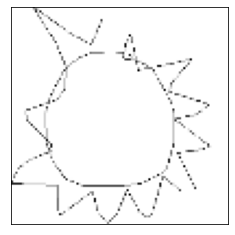

In [44]:
test_icon_indeces = set()
test_sketch_indices = set()
sketch_index = 0
for s, i in test_set.indices:
    test_sketch_indices.add(s)
    test_icon_indeces.add(i)

sketch_index =  np.random.choice(list(test_sketch_indices))


test_sketch = sketches[sketch_index]
s = test_sketch
test_sketch = np.expand_dims(test_sketch, 0)

test_icon_list = []
for i in test_icon_indeces:
    test_icon_list.append(icons[i])

test_icons = np.array(test_icon_list)
print(test_icons.shape)
plt.imshow(s)
plt.xticks([])
plt.yticks([])
plt.show()

In [46]:

for epoch in range(num_epochs):
    count = 0
    epoch_loss_avg = tf.keras.metrics.Mean()
    for _,(indices, labels) in enumerate(trainloader):
        i, s = get_batch(indices, icons, sketches)
        loss_value = train_step(i, s, labels, margin)
        epoch_loss_avg.update_state(loss_value)
        count = count + 1
        print(count)
    print("Epoch {:d}: Loss: {:.3f}".format(epoch,epoch_loss_avg.result()))
    if epoch%1==0:
    
        sketch_repr = siameseModel(test_sketch)
        print(sketch_repr.shape)
        sketch_representations = np.tile(sketch_repr, len(test_icons)).reshape(len(test_icons), 64)
        print(sketch_representations.shape)
        
        icon_representations = []
        for i in range(len(test_icons)):
            icon_repr =  siameseModel(np.expand_dims(test_icons[i], 0))
            icon_representations.append(icon_repr)
        icon_representations = np.vstack(icon_representations)

        diff = np.sqrt(np.mean((sketch_representations - icon_representations)**2, -1))
        
        top_k = np.argsort(diff)[:20]
        #print ('##' + str(epoch) + ' : loss == ' + str(loss_))

        plt.figure(figsize=(20, 20))
        for i in range(20):    
            plt.subplot(1, 20, i+1)
            plt.imshow(test_icons[top_k[i]])
            plt.xticks([])
            plt.yticks([])
        plt.show()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
Epoch 0: Loss: 4.925
(1, 64)
(97, 64)


NameError: name 'test_icon_paths' is not defined

(1, 64)
(97, 64)


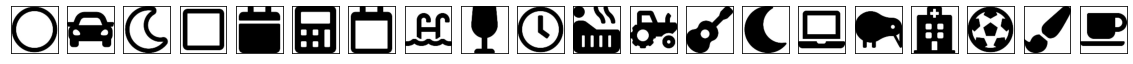

In [48]:
if epoch%1==0:
    
        sketch_repr = siameseModel(test_sketch)
        print(sketch_repr.shape)
        sketch_representations = np.tile(sketch_repr, len(test_icons)).reshape(len(test_icons), 64)
        print(sketch_representations.shape)
        
        icon_representations = []
        for i in range(len(test_icons)):
            icon_repr =  siameseModel(np.expand_dims(test_icons[i], 0))
            icon_representations.append(icon_repr)
        icon_representations = np.vstack(icon_representations)

        diff = np.sqrt(np.mean((sketch_representations - icon_representations)**2, -1))
        
        top_k = np.argsort(diff)[:20]
        #print ('##' + str(epoch) + ' : loss == ' + str(loss_))

        plt.figure(figsize=(20, 20))
        for i in range(20):    
            plt.subplot(1, 20, i+1)
            plt.imshow(test_icons[top_k[i]])
            plt.xticks([])
            plt.yticks([])
        plt.show()